In [1]:
# Project-IE590: Deep Learning for Machine Vision
# Keras Implementation of InceptionResNetV2
# Author: Varun Aggarwal`

In [1]:
# ensures back compatibility
from tensorflow.keras import backend as K

# for reading and preprocessing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# inceptionv4 model from keras with pretrained weights
from tensorflow.python.keras.applications.resnet import ResNet50, preprocess_input
import tensorflow as tf
# inception_resnet_v2.InceptionResNetV2

# for plots et al.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn


In [3]:
DATASET_PATH  = './weed_data'
IMAGE_SIZE    = (300, 300)
NUM_CLASSES   = 4
BATCH_SIZE    = 8
NUM_EPOCHS    = 20
WEIGHTS_FINAL = 'model-resnet_50-final.h5'

In [4]:
# specify data augmentation parameters for training images
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)


valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/val',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 270 images belonging to 4 classes.
Found 91 images belonging to 4 classes.


In [5]:
# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

****************
Class #0 = cocklebur
Class #1 = foxtail
Class #2 = pigweed
Class #3 = ragweed
****************


In [6]:
# resnet50 - model setup
model = ResNet50(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))


94773248/94765736 [==============================] - 18s 0us/step


In [7]:
# adding final FC layer at the end of model
x = model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense( NUM_CLASSES,
                      activation='softmax',
                      name='softmax')(x)

model = Model(inputs=model.input,
              outputs=output_layer)


# ensure all layers are trainable
for layer in model.layers:
    layer.trainable = True

# setting up optimizer for model
model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [5]:
# load saved weights
model.load_weights(WEIGHTS_FINAL)

In [9]:
# train the model
hist = model.fit_generator(train_batches,
                    steps_per_epoch = train_batches.samples // BATCH_SIZE,
                    validation_data = valid_batches,
                    validation_steps = valid_batches.samples // BATCH_SIZE,
                    epochs = NUM_EPOCHS)

Epoch 1/20
33/33 [==============================] - 27s 824ms/step - loss: 2.9504 - accuracy: 0.3092 - val_loss: 1.5467 - val_accuracy: 0.4773
Epoch 2/20
33/33 [==============================] - 27s 817ms/step - loss: 2.4979 - accuracy: 0.3969 - val_loss: 1.1317 - val_accuracy: 0.5682
Epoch 3/20
33/33 [==============================] - 26s 802ms/step - loss: 1.7018 - accuracy: 0.5153 - val_loss: 0.9553 - val_accuracy: 0.7045
Epoch 4/20
33/33 [==============================] - 25s 763ms/step - loss: 1.2414 - accuracy: 0.6031 - val_loss: 0.7793 - val_accuracy: 0.7614
Epoch 5/20
33/33 [==============================] - 25s 750ms/step - loss: 1.3070 - accuracy: 0.6145 - val_loss: 0.7984 - val_accuracy: 0.7727
Epoch 6/20
33/33 [==============================] - 25s 745ms/step - loss: 1.0218 - accuracy: 0.7252 - val_loss: 0.6326 - val_accuracy: 0.8295
Epoch 7/20
33/33 [==============================] - 25s 745ms/step - loss: 0.8265 - accuracy: 0.7290 - val_loss: 0.6199 - val_accuracy: 0.8295

In [10]:
# save trained weights
model.save(WEIGHTS_FINAL)

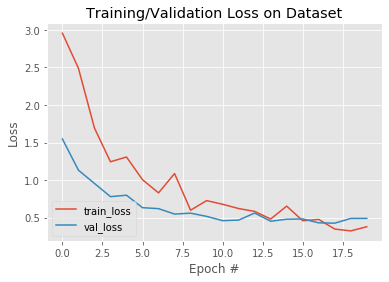

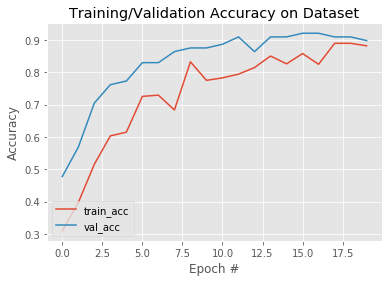

In [11]:
# Plot Results

N=NUM_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")

plt.title("Training/Validation Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot_loss.png")

plt.figure()
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")

plt.title("Training/Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [12]:
# test model

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_batches = test_datagen.flow_from_directory(DATASET_PATH + '/test',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=1)

out = model.evaluate_generator(test_batches, use_multiprocessing=True)
print(list(zip(model.metrics_names,out)))

Found 88 images belonging to 4 classes.
[('loss', 0.1782851284554041), ('accuracy', 0.96590906)]


In [13]:
test_batches.reset()

In [14]:
Y_pred = model.predict_generator(test_batches, use_multiprocessing=True)
# print(len(Y_pred))



 Classification Report

              precision    recall  f1-score   support

   cocklebur       1.00      1.00      1.00        17
     foxtail       0.93      1.00      0.97        14
     pigweed       0.97      0.97      0.97        34
     ragweed       0.95      0.91      0.93        23

    accuracy                           0.97        88
   macro avg       0.96      0.97      0.97        88
weighted avg       0.97      0.97      0.97        88



Confusion Matrix



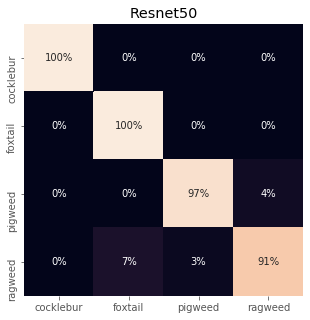

In [16]:
y_pred = np.argmax(Y_pred, axis=1)

print('\n\n Classification Report\n')
target_names = list(test_batches.class_indices.keys())
print(classification_report(list(test_batches.classes), y_pred, target_names=target_names))


print('\n\nConfusion Matrix\n')
cm = confusion_matrix(test_batches.classes, y_pred)

row_sums = cm.sum(axis=1)
cm = cm / row_sums

df_cm = pd.DataFrame(cm, index = ['cocklebur','foxtail','pigweed','ragweed'], columns = ['cocklebur','foxtail','pigweed','ragweed'])
# print(df_cm)

# flights = df_cm.pivot("month", "year", "passengers")

plt.figure(figsize = (5,5))
plt.title('Resnet50')
sn.heatmap(df_cm, annot=True, fmt='0.0%', cbar=False)
plt.savefig('Resnet50.png')

In [ ]:
# Implementation as explained in: https://arxiv.org/pdf/1602.07261v1.pdf
# Code Source: Keras InceptionResetV2 (https://jkjung-avt.github.io/keras-inceptionresnetv2/)